In [1]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [2]:
import numpy as np
import meep as mp
from autograd import numpy as npa
import meep.adjoint as mpa
from matplotlib import pyplot as plt

Starting forward run...
Starting adjoint run...


/usr/local/lib/python3.8/site-packages/meep/adjoint/filter_source.py:92: RuntimeWarning: divide by zero encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat.T)**2/np.abs(H)**2)


Calculating gradient...


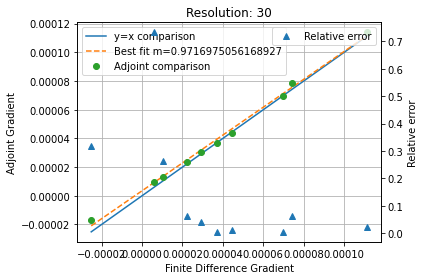

In [3]:
mp.quiet(quietval=True)
seed = 240
np.random.seed(seed)

resolution = 30

Sx = 5
Sy = 5
sxy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [0,-1,0]
source_size    = mp.Vector3(0,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)

source = [mp.Source(src,component=mp.Ez,
                    size = source_size,
                    center=source_center)]


design_region_resolution = 10

Nx = design_region_resolution//2
Ny = design_region_resolution//2

Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_SUM')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(0.5, 0.5, 0)))




geometry = [
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)# design region
]




sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

far_x = mp.Vector3(2000, 2000, 0)
NearRegions = [mp.Near2FarRegion(center=mp.Vector3(0,+0.125*sxy), size=mp.Vector3(0.55*sxy,0), weight=+1)]


Far0 = mpa.Far_Coefficients(sim, NearRegions ,far_x)


ob_list = [Far0]




def J1(alpha):
    return npa.abs(alpha[0,2])**2 + npa.abs(alpha[1,3])**3

def J2(alpha):
    return npa.abs(alpha[0,0])**2 + npa.abs(alpha[1,5])**3

def J3(alpha):
    return npa.abs(alpha[0,0])**2 + npa.abs(alpha[0,5])**3




opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J1,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df = 0.03,
    nf = 3,
    decay_fields=[mp.Ez]
)




x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])


f0, dJ_deps = opt()



db = 1e-3
choose = 10

g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

g_adjoint = np.sum(dJ_deps, axis=1)


(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)


fig, ax1 = plt.subplots()

ax1.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
ax1.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
ax1.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
ax1.set_xlabel('Finite Difference Gradient')
ax1.set_ylabel('Adjoint Gradient')
ax1.tick_params(axis='y')
plt.legend()
plt.grid(True)


g_discrete = g_discrete.reshape(-1, 1)
g_adjoint = g_adjoint.reshape(-1,1)
ax2 = ax1.twinx()
ax2.plot(g_discrete, np.abs((g_discrete-g_adjoint[idx])/g_discrete),'^',label='Relative error')
ax2.set_ylabel('Relative error')
ax2.tick_params(axis='y')



plt.title('Resolution: {}'.format(resolution))
plt.legend()
fig.tight_layout()
plt.show()

Starting forward run...
Starting adjoint run...


/usr/local/lib/python3.8/site-packages/meep/adjoint/filter_source.py:92: RuntimeWarning: divide by zero encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat.T)**2/np.abs(H)**2)


Calculating gradient...


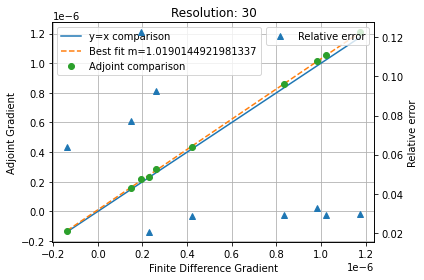

In [4]:
source = [mp.Source(src,component=mp.Ex, size = source_size, center=source_center)]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)


Far0 = mpa.Far_Coefficients(sim, NearRegions ,far_x)


ob_list = [Far0]

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J2,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df = 0.03,
    nf = 3,
    decay_fields=[mp.Ex]
)





f0, dJ_deps = opt()


g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

g_adjoint = np.sum(dJ_deps, axis=1)


(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)


fig, ax1 = plt.subplots()

ax1.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
ax1.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
ax1.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
ax1.set_xlabel('Finite Difference Gradient')
ax1.set_ylabel('Adjoint Gradient')
ax1.tick_params(axis='y')
plt.legend()
plt.grid(True)


g_discrete = g_discrete.reshape(-1, 1)
g_adjoint = g_adjoint.reshape(-1,1)
ax2 = ax1.twinx()
ax2.plot(g_discrete, np.abs((g_discrete-g_adjoint[idx])/g_discrete),'^',label='Relative error')
ax2.set_ylabel('Relative error')
ax2.tick_params(axis='y')



plt.title('Resolution: {}'.format(resolution))
plt.legend()
fig.tight_layout()
plt.show()

Starting forward run...
Starting adjoint run...
Calculating gradient...


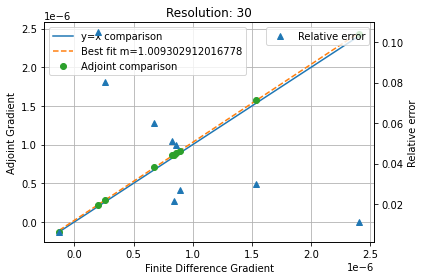

In [7]:
source = [mp.Source(src,component=mp.Ex, size = source_size, center=source_center)]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)


Far0 = mpa.Far_Coefficients(sim, NearRegions ,far_x)


ob_list = [Far0]

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J2,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df = 0.03,
    nf = 3,
    decay_fields=[mp.Ex],
    decay_by=2e-5
)





f0, dJ_deps = opt()


g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

g_adjoint = np.sum(dJ_deps, axis=1)


(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)


fig, ax1 = plt.subplots()

ax1.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
ax1.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
ax1.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
ax1.set_xlabel('Finite Difference Gradient')
ax1.set_ylabel('Adjoint Gradient')
ax1.tick_params(axis='y')
plt.legend()
plt.grid(True)


g_discrete = g_discrete.reshape(-1, 1)
g_adjoint = g_adjoint.reshape(-1,1)
ax2 = ax1.twinx()
ax2.plot(g_discrete, np.abs((g_discrete-g_adjoint[idx])/g_discrete),'^',label='Relative error')
ax2.set_ylabel('Relative error')
ax2.tick_params(axis='y')



plt.title('Resolution: {}'.format(resolution))
plt.legend()
fig.tight_layout()
plt.show()